**Entendendo a demanda**

Quando uma pessoa cliente realiza uma compra e recebe o produto, ela tem a oportunidade de deixar uma avaliação.

Nesse processo, atribui uma nota ao item e redige um comentário detalhando sua experiência, que pode ser positiva ou negativa, mencionando aspectos que lhe agradaram ou desapontaram. O e-commerce recebe centenas de avaliações mensalmente.

**Desafios**

Um dos desafios que enfrentamos é a ausência de um método automático para identificar se a experiência da pessoa cliente foi positiva ou negativa. Isso revela a necessidade de um sistema capaz de classificar as avaliações de forma automática. Ao receber cada avaliação, o sistema poderá categorizar o sentimento como positivo ou negativo.

In [2]:
import pandas as pd

df = pd.read_csv('dataset_avaliacoes.csv')
df.head()

,ID_avaliacao,avaliacao,nota,sentimento
0,81841,"Esse smartphone superou minhas expectativas, r...",5,positivo
1,28031,o cheiro e muito desagradavel!! pra quem se in...,2,negativo
2,91332,"Eu fiz a compra a loja não entregou o produto,...",1,negativo
3,110045,"Atendeu minhas expectativas, só achei a luz ru...",4,positivo
4,36929,"Gostei muito, só achei que ficou a desejar a q...",5,positivo


In [3]:
df.shape

(15501, 4)

Não há dados nulos

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15501 entries, 0 to 15500
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID_avaliacao  15501 non-null  int64 
 1   avaliacao     15501 non-null  object
 2   nota          15501 non-null  int64 
 3   sentimento    15501 non-null  object
dtypes: int64(2), object(2)
memory usage: 484.5+ KB


Quantidade de sentimentos positivos e negativos

In [5]:
df.value_counts('sentimento')

sentimento
positivo    7890
negativo    7611
Name: count, dtype: int64

### Transformando textos em dados numéricos (Bag of Words (BOW) -> Bolsa de palavras)

Ainda não é possível classificar os sentimentos, pois para que o algorítmo entenda, antes é necessário processar esses dados para que se tornem numéricos.

A ferramenta *CountVetorizer* irá contar a frequência de cada palavra no texto.

A grande vantagem da técnica BOW é sua simplicidade. Ela transforma textos em números facilitando a análise e processamento por algoritmos de aprendizado de máquina. Porém, como esta técnica não considera a ordem das palavras, ele pode ignorar aspectos importantes do contexto e do significado do texto.

Mais adiante, no projeto, iremos explorar técnicas mais avançadas que superam essa limitação.

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

# Exemplo de uso:
textos = ['Comprei um produto ótimo', 'Comprei um produto ruim']

vetorizar = CountVectorizer()
bag_of_words = vetorizar.fit_transform(textos)
bag_of_words

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 8 stored elements and shape (2, 5)>

In [7]:
matriz_esparsa = pd.DataFrame.sparse.from_spmatrix(bag_of_words, columns=vetorizar.get_feature_names_out())
matriz_esparsa

,comprei,produto,ruim,um,ótimo
0,1,1,0,1,1
1,1,1,1,1,0


Em seguida, iremos implementar esta tecnica nos nossos dados

Iremos configurar o parametro *lowercase* para false para não converter todas as palavras em minúsculas.

Assim como, teremos que configurar a variável *max_features* para que a quantidade de colunas não fique muito grande, pois grandes quantidades de colunas não é o ideal do ponto de vista computacional, pois requer muito processamento e recursos.

In [8]:
vetorizar = CountVectorizer(lowercase=False, max_features=50)
bag_of_words = vetorizar.fit_transform(df['avaliacao'])
bag_of_words.shape

(15501, 50)

In [9]:
matriz_esparsa = pd.DataFrame.sparse.from_spmatrix(
    bag_of_words,
    columns=vetorizar.get_feature_names_out())
matriz_esparsa

,Não,Produto,ainda,antes,as,até,bem,bom,chegou,com,...,qualidade,que,recebi,recomendo,se,sem,tem,um,uma,veio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,1,2,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15496,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
15497,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
15498,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
15499,0,1,0,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


### Treinando o modelo

In [10]:
from sklearn.model_selection import train_test_split

SEED = 42

X_train, X_test, y_train, y_test = train_test_split(bag_of_words, df['sentimento'], random_state=SEED)

In [11]:
from sklearn.linear_model import LogisticRegression

regressao_logistica = LogisticRegression()

regressao_logistica.fit(X_train, y_train)

acuracia = regressao_logistica.score(X_test, y_test)
print(f'Acurácia: {acuracia*100:.2f}%')

Acurácia: 80.08%


### Quais as palavras mais utilizadas nas avaliações?

Como podemos visualizar as palavras mais utilizadas nas avaliações?

In [12]:
from wordcloud import WordCloud

todas_palavras = [texto for texto in df['avaliacao']]
todas_palavras

['Esse smartphone superou minhas expectativas, recomendo',
 'o cheiro e muito desagradavel!! pra quem se incomoda  nao recomendoo..',
 'Eu fiz a compra a loja não entregou o produto, a compra foi feita no cartão de credito e ate o momento a loja também nao me devolveu o valor da compra.',
 'Atendeu minhas expectativas, só achei a luz ruim, mas nada que dificulte seu funcionamento.',
 'Gostei muito, só achei que ficou a desejar a qualidade das fotos. Achei que fosse bem melhor .',
 'Comprei o produto e ñ tinha para entrega isso não foi legal!!!!!!',
 'o produto pode até ser bom ,mais só posso avalia-lo depois que for feito a troca para eu usa-lo, pois estou esperando a troca ser feita o que recebi veio quebrado',
 'já enviei duas reclamações, mas não obtive resposta. recebi o produto quebrado e quero que seja enviado outro. estou no aguardo para saber o que fazer. att. Cármen',
 'nao recebi o produto, pois voces nao cumpriram o compromisso firmado de entregar ate hoje 23/05/18. PESSIMA 

O gráfico abaixo entregará uma nuvem de palavras independente do sentimento.

(np.float64(-0.5), np.float64(799.5), np.float64(499.5), np.float64(-0.5))

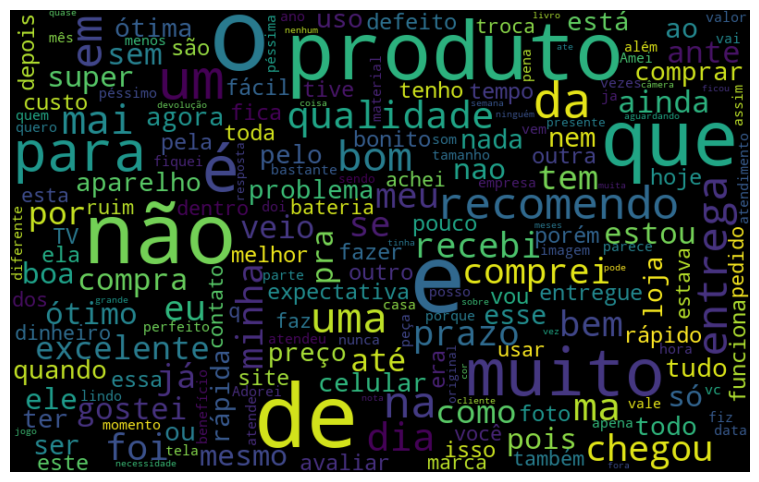

In [13]:
import matplotlib.pyplot as plt

# Primeiramente iremos unir todas as frases em uma só string
todas_palavras = ' '.join([texto for texto in df['avaliacao']])

# Collocations como 'False' faz o wordcloud considerar apenas palavras únicas e não uma junção de palavras (frase)
nuvem_palavras = WordCloud(width=800, height=500, max_font_size=110, collocations=False).generate(todas_palavras)

plt.figure(figsize=(12,6))
plt.imshow(nuvem_palavras, interpolation='bilinear')
plt.axis('off')

Abaixo iremos criar uma função para poder gerar uma nuvem de palavras com filtro por sentimento, onde será possível visualizar todas as palavras que são definidas como negativas e positivas.

In [14]:
def nuvem_palavras(texto, coluna_texto, sentimento):
    # Pega todas as linhas com o sentimento específico e retorna todos os valores da coluna especificada
    texto_sentimento = texto.query(f'sentimento == "{sentimento}"')[coluna_texto]
    
    texto_unido = ' '.join(texto_sentimento)
    
    nuvem_palavras = WordCloud(width=800, height=500, max_font_size=110, collocations=False).generate(texto_unido)
    plt.figure(figsize=(12,6))
    plt.imshow(nuvem_palavras, interpolation='bilinear')
    plt.axis('off')
    plt.show()

Todas as palavras com sentimento **negativo**.

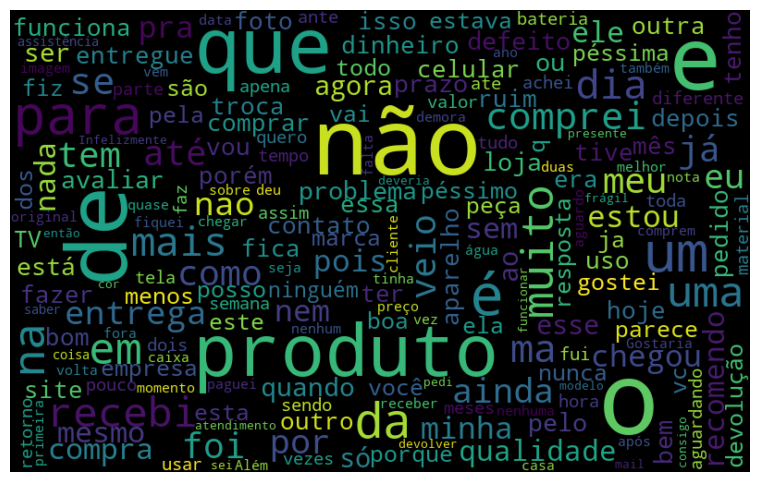

In [15]:
nuvem_palavras(df, 'avaliacao', 'negativo')

Todas as palavras com sentimento **positivo**.

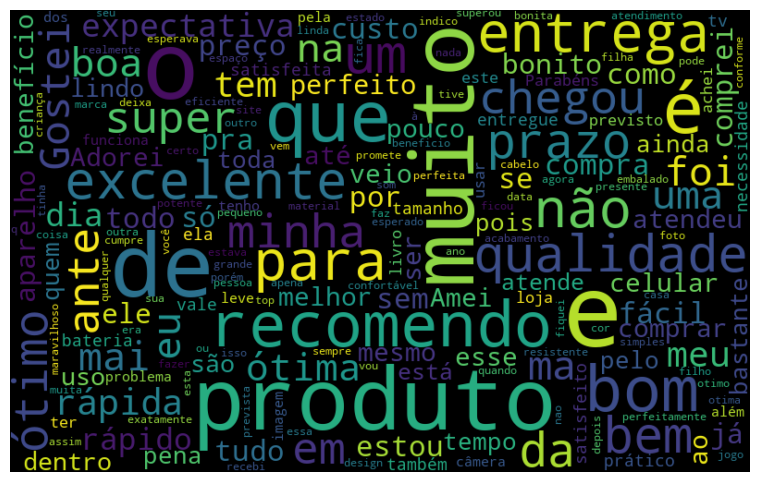

In [16]:
nuvem_palavras(df, 'avaliacao', 'positivo')

### Qual a frequência das palavras?

Antes de verificar a frequência das palavras no texto precisamos separa-las.

Iremos separar o texto em unidades menores chamados de *tokens* com a técnica de **Tokenização** com a biblioteca *nltk*.

A **tokenização** é o processo de dividir o texto em *tokens*, que são unidades menores, como palavras ou subpalavras. Seria como um *frase.split(' ')* no C# ou Javascript. 

**Exemplo:**
- ['Este','produto','é','excelente']

A *tokenização* é um dos primeiros passos para manipular textos.

In [20]:
#import nltk
#nltk.download('all')

from nltk import tokenize, FreqDist

# A técnica de tokenização para este caso será de espaços em branco
tokenizer = tokenize.WhitespaceTokenizer()
token_frases = tokenizer.tokenize(todas_palavras) # Aqui iremos utilizar todas as frases do nosso dataset concatenadas em apenas uma string
token_frases

['Esse',
 'smartphone',
 'superou',
 'minhas',
 'expectativas,',
 'recomendo',
 'o',
 'cheiro',
 'e',
 'muito',
 'desagradavel!!',
 'pra',
 'quem',
 'se',
 'incomoda',
 'nao',
 'recomendoo..',
 'Eu',
 'fiz',
 'a',
 'compra',
 'a',
 'loja',
 'não',
 'entregou',
 'o',
 'produto,',
 'a',
 'compra',
 'foi',
 'feita',
 'no',
 'cartão',
 'de',
 'credito',
 'e',
 'ate',
 'o',
 'momento',
 'a',
 'loja',
 'também',
 'nao',
 'me',
 'devolveu',
 'o',
 'valor',
 'da',
 'compra.',
 'Atendeu',
 'minhas',
 'expectativas,',
 'só',
 'achei',
 'a',
 'luz',
 'ruim,',
 'mas',
 'nada',
 'que',
 'dificulte',
 'seu',
 'funcionamento.',
 'Gostei',
 'muito,',
 'só',
 'achei',
 'que',
 'ficou',
 'a',
 'desejar',
 'a',
 'qualidade',
 'das',
 'fotos.',
 'Achei',
 'que',
 'fosse',
 'bem',
 'melhor',
 '.',
 'Comprei',
 'o',
 'produto',
 'e',
 'ñ',
 'tinha',
 'para',
 'entrega',
 'isso',
 'não',
 'foi',
 'legal!!!!!!',
 'o',
 'produto',
 'pode',
 'até',
 'ser',
 'bom',
 ',mais',
 'só',
 'posso',
 'avalia-lo',
 'depo

**Frequência de cada palavra**

In [ ]:
frequencia = FreqDist(token_frases)

freq_df = pd.DataFrame({
    'palavra': list(frequencia.keys()),
    'frequencia': list(frequencia.values())
})

# Exibe as 10 palavras mais frequentes
freq_df.sort_values('frequencia', ascending=False).head(10)

,palavra,frequencia
8,e,11813
6,o,10865
29,de,10280
19,a,8873
46,que,7657
22,não,7286
163,é,4786
63,produto,4765
177,com,4641
130,do,4583


Visualização das 10 palavras mais utilizadas

[Text(0, 0.5, 'Contagem'), Text(0.5, 0, 'Palavra')]

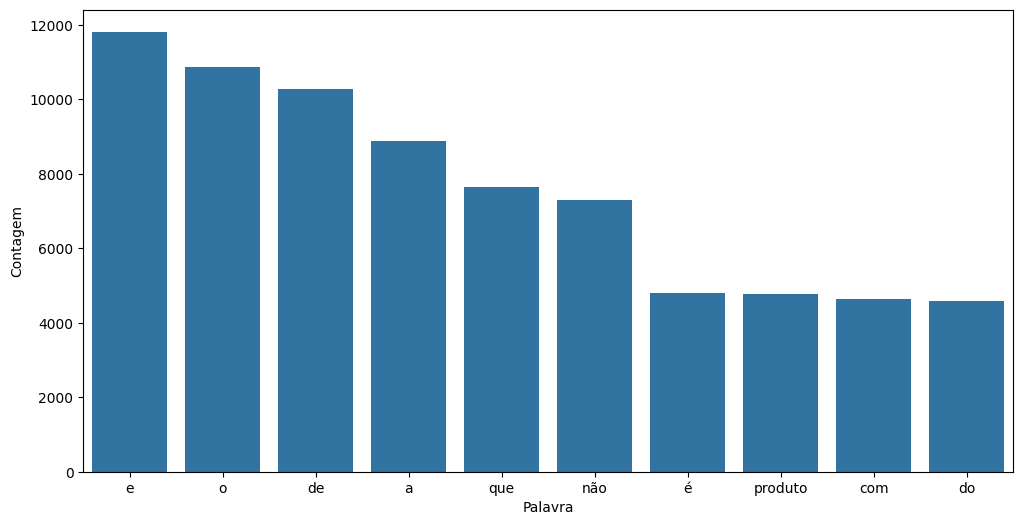

In [27]:
import seaborn as sns

plt.figure(figsize=(12,6))
ax = sns.barplot(freq_df.sort_values('frequencia', ascending=False).head(10), x='palavra', y='frequencia')
ax.set(ylabel='Contagem', xlabel='Palavra')